# ElderCompanion: A Gemma 3n-Powered Assistant for Healthy Aging

In [1]:
import os
import sys
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import cv2
from tqdm.auto import tqdm
import warnings
import json
import re
import random
from datetime import datetime
import logging
from pathlib import Path
import requests
from IPython.display import display, Audio, HTML, clear_output

# Configure environment
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print(f"Notebook initialized at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python version: {sys.version.split()[0]}")
print(f"Torch version: {torch.__version__}")

# Create directories for our project
base_dir = Path("eldercompanion")
dirs = [
    base_dir / "data",
    base_dir / "models",
    base_dir / "outputs",
    base_dir / "logs",
    base_dir / "media" / "images",
    base_dir / "media" / "audio"
]

for dir_path in dirs:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {dir_path}")

Notebook initialized at 2025-06-28 08:57:33
Python version: 3.11.11
Torch version: 2.6.0+cu124
Created directory: eldercompanion/data
Created directory: eldercompanion/models
Created directory: eldercompanion/outputs
Created directory: eldercompanion/logs
Created directory: eldercompanion/media/images
Created directory: eldercompanion/media/audio


# 1. Introduction and Problem Statement

## The Challenge of Aging in the Modern World

The global population is aging rapidly. By 2050, one in six people worldwide will be over the age of 65, up from one in eleven in 2019. This demographic shift brings significant challenges:

- **Isolation and Loneliness**: Many elderly individuals live alone with limited social contact
- **Healthcare Management**: Complex medication schedules and chronic condition monitoring
- **Cognitive Decline**: Memory issues and cognitive impairments requiring specialized support
- **Limited Digital Literacy**: Difficulty accessing modern digital services and information
- **Safety Concerns**: Fall risks, emergency response needs, and daily safety monitoring

While technology has the potential to address these challenges, most current solutions are cloud-based, require internet connectivity, involve complex interfaces, or raise privacy concerns that can be particularly alarming for elderly users.

## Our Solution: ElderCompanion

We propose **ElderCompanion**, a Gemma 3n-powered application that runs directly on a tablet or smartphone, providing a private, offline-first companion for healthy aging. ElderCompanion leverages Gemma 3n's unique capabilities to deliver:

1. **Medication Management**: Visual recognition of pills and packaging, reminders, and interaction checks
2. **Cognitive Stimulation**: Personalized exercises and conversations that adapt to cognitive levels
3. **Health Monitoring**: Voice analysis for early detection of cognitive changes or health issues
4. **Emergency Response**: Fall detection through device cameras and one-touch assistance
5. **Companionship**: Warm, accessible conversation partner with context memory of important life events

### Why Gemma 3n is the Perfect Foundation

Gemma 3n's capabilities directly address the core requirements for an effective elder care solution:

- **On-Device Processing**: Ensures privacy and reliable operation even in areas with poor connectivity
- **Multimodal Understanding**: Processes images (pill identification, fall detection), audio (voice analysis, commands), and text (conversation)
- **Efficiency**: Runs smoothly on consumer devices like tablets without requiring expensive hardware
- **Multilingual Support**: Serves diverse elderly populations in their native languages
- **Offline Operation**: Provides continuous support regardless of internet access

In this notebook, we'll build a prototype of ElderCompanion using Gemma 3n, demonstrating how on-device AI can create a meaningful impact in elder care while preserving privacy and accessibility.

In [2]:
# Install required dependencies
!pip install -q transformers==4.38.0 accelerate==0.27.0 bitsandbytes==0.41.0 
!pip install -q safetensors==0.4.1 sentencepiece==0.1.99 peft==0.8.0
!pip install -q librosa==0.10.1 opencv-python==4.8.0.76 scikit-learn==1.3.0
!pip install -q ipywidgets==8.1.1 matplotlib==3.7.3 seaborn==0.13.0

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # Set seed for reproducibility
    torch.cuda.manual_seed(42)
else:
    print("No GPU detected. Using CPU.")
    
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Function to load a simplified representation of Gemma 3n
def load_gemma_3n_model(model_size="4B", quantization=None):
    """
    Load Gemma 3n model with appropriate configurations for on-device deployment
    
    Parameters:
    - model_size: Size variant of Gemma 3n to load ("2B", "4B", "5B", or "8B")
    - quantization: Quantization level (None, "4bit", "8bit")
    
    Returns:
    - Dictionary with model and tokenizer
    """
    from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
    
    print(f"Loading Gemma 3n {model_size} model...")
    
    # For the hackathon, we'll use the existing Gemma model as a stand-in 
    # Update this when Gemma 3n is released
    MODEL_ID = "google/gemma-2b" if model_size in ["2B", "4B"] else "google/gemma-7b"
    
    # Configure quantization if specified
    if quantization == "4bit":
        print("Applying 4-bit quantization...")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True
        )
    elif quantization == "8bit":
        print("Applying 8-bit quantization...")
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    else:
        quantization_config = None
    
    # Get token from environment if available
    hf_token = os.environ.get("HUGGINGFACE_TOKEN", None)
    
    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(
            MODEL_ID,
            token=hf_token
        )
        
        # Load model with appropriate configurations
        model_kwargs = {
            "device_map": "auto",
            "token": hf_token
        }
        
        if quantization_config:
            model_kwargs["quantization_config"] = quantization_config
        else:
            model_kwargs["torch_dtype"] = torch.bfloat16
            
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            **model_kwargs
        )
        
        print(f"Model loaded successfully with {model.num_parameters()/1e9:.1f}B parameters")
        
        return {
            "model": model,
            "tokenizer": tokenizer,
            "model_id": MODEL_ID,
            "size": model_size,
            "quantization": quantization
        }
        
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        print(f"Failed to load model: {e}")
        print("Using simulation mode for development...")
        
        return {
            "model": None,
            "tokenizer": None,
            "model_id": MODEL_ID,
            "size": model_size,
            "quantization": quantization,
            "simulation": True
        }

# Load the Gemma 3n model
# Using 4-bit quantization for efficient on-device deployment
gemma_3n = load_gemma_3n_model(model_size="4B", quantization="4bit")

# Helper function for text generation with the model
def generate_response(prompt, max_length=500, temperature=0.7, top_p=0.9):
    """Generate a response from the model"""
    
    # If we're in simulation mode, return predefined responses
    if gemma_3n.get("simulation", False):
        # Simple simulation for development purposes
        responses = {
            "medication": "I see you're holding a pill that appears to be Lisinopril 10mg, used for blood pressure. The recommended dosage is once daily. Would you like me to set a reminder for your next dose?",
            "memory": "Based on our previous conversations, today might be a good day to call your daughter Sarah. You mentioned she was going to have an important presentation at work today.",
            "exercise": "It's been 2 days since your last stretching routine. Would you like me to guide you through some gentle seated exercises that can help with your arthritis?",
            "emergency": "I've detected what might be a fall. Are you okay? If you need help, I can call your emergency contact or emergency services.",
            "fallback": "I'm here to help you stay healthy and connected. Would you like to check your medication schedule, do some memory exercises, or perhaps look at some family photos?"
        }
        
        # Choose a relevant predefined response based on keywords in the prompt
        for key, response in responses.items():
            if key in prompt.lower():
                return response
        return responses["fallback"]
    
    # For real model
    try:
        inputs = gemma_3n["tokenizer"](prompt, return_tensors="pt").to(device)
        
        outputs = gemma_3n["model"].generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_p=top_p,
            do_sample=True
        )
        
        return gemma_3n["tokenizer"].decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        logger.error(f"Error generating response: {e}")
        return "I'm having trouble processing that request right now. Could you try again?"

# Test the model with a basic prompt
test_prompt = "How can AI help elderly people maintain their independence while aging at home?"
print("\nTesting model response to prompt about elderly care:\n")
print(generate_response(test_prompt))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cur

In [3]:
# Core ElderCompanion features

class ElderCompanion:
    """Main class for the ElderCompanion application"""
    
    def __init__(self, model_package=None, user_profile=None):
        """Initialize the ElderCompanion with model and user profile"""
        self.model_package = model_package or gemma_3n
        self.using_simulation = self.model_package.get("simulation", False)
        
        # Load or create user profile
        self.user_profile = user_profile or self._create_default_profile()
        
        # Initialize memory for conversation context
        self.conversation_history = []
        self.max_history_length = 10
        
        # Track active reminders and alerts
        self.reminders = []
        
        # Initialize components
        self.medication_manager = MedicationManager(self)
        self.cognitive_assistant = CognitiveAssistant(self)
        self.health_monitor = HealthMonitor(self)
        self.emergency_system = EmergencySystem(self)
        
        print(f"ElderCompanion initialized for user: {self.user_profile['name']}")
        
    def _create_default_profile(self):
        """Create a default user profile for demonstration"""
        return {
            "name": "Eleanor Johnson",
            "age": 78,
            "emergency_contacts": [
                {"name": "Sarah (Daughter)", "phone": "555-123-4567"},
                {"name": "Dr. Martinez", "phone": "555-987-6543"}
            ],
            "medications": [
                {"name": "Lisinopril", "dosage": "10mg", "schedule": "Daily at 8:00 AM", "purpose": "Blood pressure"},
                {"name": "Metformin", "dosage": "500mg", "schedule": "Twice daily with meals", "purpose": "Type 2 diabetes"},
                {"name": "Vitamin D", "dosage": "1000 IU", "schedule": "Daily", "purpose": "Bone health"}
            ],
            "health_conditions": ["Hypertension", "Type 2 diabetes", "Osteoarthritis"],
            "cognitive_level": "Mild cognitive impairment",
            "preferences": {
                "reminder_frequency": "High",
                "conversation_topics": ["Family", "Gardening", "Classic movies", "History"],
                "voice_volume": "Louder",
                "text_size": "Large"
            },
            "family_members": [
                {"name": "Sarah", "relation": "Daughter", "key_dates": "Birthday: March 15"},
                {"name": "Michael", "relation": "Son", "key_dates": "Birthday: October 8"},
                {"name": "Emma and Jacob", "relation": "Grandchildren", "key_dates": "School play: Next Friday"}
            ],
            "life_memories": [
                "Grew up in Cincinnati, Ohio",
                "Worked as a librarian for 35 years",
                "Loves gardening, especially growing tomatoes",
                "Traveled to Europe in 1975"
            ]
        }
        
    def chat(self, user_message):
        """Process a user message and generate a response"""
        # Add message to conversation history
        self.conversation_history.append({"role": "user", "content": user_message})
        
        # Truncate history if needed
        if len(self.conversation_history) > self.max_history_length:
            self.conversation_history = self.conversation_history[-self.max_history_length:]
        
        # Format conversation history and user profile for context
        context = self._format_context()
        
        # Construct the complete prompt
        prompt = f"""
You are ElderCompanion, a helpful, compassionate assistant for {self.user_profile['name']}, 
who is {self.user_profile['age']} years old.

USER PROFILE:
{json.dumps(self.user_profile, indent=2)}

CONVERSATION HISTORY:
{context}

USER: {user_message}

As ElderCompanion, respond in a helpful, warm, and clear manner. 
Keep responses concise and easy to understand. Speak directly to the user.
If the user mentions any health concerns or emergencies, treat them with appropriate priority.
"""
        
        # Generate response
        response = generate_response(prompt)
        
        # Add response to conversation history
        self.conversation_history.append({"role": "assistant", "content": response})
        
        return response
    
    def _format_context(self):
        """Format conversation history for context"""
        formatted = ""
        for entry in self.conversation_history:
            role = "USER" if entry["role"] == "user" else "ASSISTANT"
            formatted += f"{role}: {entry['content']}\n\n"
        return formatted
    
    def analyze_image(self, image_path, context=""):
        """Analyze an image using Gemma 3n's multimodal capabilities"""
        # In a real implementation, this would process the image and include it in the prompt
        # For simulation, we'll return predefined responses based on the context
        
        if "medication" in context.lower():
            return self.medication_manager.identify_medication(image_path)
        elif "fall" in context.lower() or "emergency" in context.lower():
            return self.emergency_system.assess_situation(image_path)
        else:
            # Generic image analysis
            return "I can see this image. What would you like me to help you with regarding it?"
    
    def analyze_audio(self, audio_path, context=""):
        """Analyze audio using Gemma 3n's multimodal capabilities"""
        # In a real implementation, this would process the audio and include it in the prompt
        # For simulation, we'll return predefined responses based on the context
        
        if "health" in context.lower():
            return self.health_monitor.analyze_voice(audio_path)
        else:
            # Generic transcription
            return "I've processed the audio. How else can I assist you today?"

class MedicationManager:
    """Manages medication recognition, reminders, and interactions"""
    
    def __init__(self, companion):
        self.companion = companion
    
    def identify_medication(self, image_path):
        """Identify medication from an image"""
        # In a real implementation, this would use Gemma 3n's multimodal capabilities
        # to identify the medication from the image
        
        if self.companion.using_simulation:
            # Simulated response for development
            medications = self.companion.user_profile["medications"]
            if medications:
                medication = random.choice(medications)
                return f"This appears to be {medication['name']} {medication['dosage']}. It's used for {medication['purpose']} and should be taken {medication['schedule']}."
            return "I don't recognize this medication. Would you like me to add it to your medication list?"
        
        # For real model implementation
        prompt = f"""
        <img>{self._encode_image(image_path)}</img>
        
        You are looking at an image of medication. Identify the medication if possible, 
        including name, dosage, and any visible details. Compare with the user's known medications:
        {json.dumps(self.companion.user_profile['medications'])}
        
        If it's a known medication, provide information about its purpose and schedule.
        If it's not recognizable, express that clearly and offer to add it to the medication list.
        """
        
        return generate_response(prompt)
    
    def _encode_image(self, image_path):
        """Encode image to base64 for model input"""
        import base64
        
        try:
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode("utf-8")
        except Exception as e:
            logger.error(f"Error encoding image: {e}")
            return ""
    
    def set_reminder(self, medication_name, time):
        """Set a reminder for medication"""
        self.companion.reminders.append({
            "type": "medication",
            "medication": medication_name,
            "time": time,
            "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })
        return f"I've set a reminder for {medication_name} at {time}."
    
    def get_schedule_summary(self):
        """Get a summary of the user's medication schedule"""
        medications = self.companion.user_profile["medications"]
        if not medications:
            return "You don't have any medications in your profile yet."
        
        summary = "Here's your medication schedule:\n\n"
        for med in medications:
            summary += f"- {med['name']} ({med['dosage']}): {med['schedule']} - For {med['purpose']}\n"
        
        return summary

class CognitiveAssistant:
    """Provides cognitive exercises and memory support"""
    
    def __init__(self, companion):
        self.companion = companion
        self.exercise_types = ["memory", "attention", "language", "problem-solving"]
    
    def generate_exercise(self, exercise_type=None):
        """Generate a cognitive exercise based on the user's cognitive level"""
        if exercise_type is None:
            exercise_type = random.choice(self.exercise_types)
        
        cognitive_level = self.companion.user_profile["cognitive_level"]
        
        if self.companion.using_simulation:
            # Simulated exercises
            exercises = {
                "memory": {
                    "easy": "Let's practice short-term memory. I'll give you three words to remember: Apple, Chair, Blue. We'll come back to these words after a few questions.",
                    "medium": "I'll name five objects. Try to remember them and repeat them back to me after we talk about something else: Book, Cat, Window, Phone, Clock.",
                    "hard": "I'll give you a short story, and afterwards I'll ask you some details about it. Listen carefully."
                },
                "attention": {
                    "easy": "Let's do a simple attention exercise. Count backwards from 20 to 1.",
                    "medium": "I'll say some letters. Tap the screen each time you hear the letter 'A': L K A T E A M P A",
                    "hard": "For this exercise, name all the months of the year backwards, starting from December."
                }
            }
            
            difficulty = "medium"
            if "mild" in cognitive_level.lower():
                difficulty = "easy"
            elif "moderate" in cognitive_level.lower():
                difficulty = "medium"
            elif "severe" in cognitive_level.lower():
                difficulty = "hard"
            
            if exercise_type in exercises and difficulty in exercises[exercise_type]:
                return exercises[exercise_type][difficulty]
            else:
                return "Let's do a simple memory exercise. Try to remember what you had for breakfast today and tell me about it."
        
        # For real model implementation
        prompt = f"""
        Generate a cognitive exercise for a {self.companion.user_profile['age']}-year-old with {cognitive_level}.
        The exercise should focus on {exercise_type} skills.
        Make it engaging, clear, and appropriate for their cognitive level.
        Keep instructions brief and easy to understand.
        Include a gentle encouragement and clear instructions on how to respond.
        """
        
        return generate_response(prompt)
    
    def reminisce_memory(self):
        """Generate a reminiscence prompt based on the user's life memories"""
        memories = self.companion.user_profile["life_memories"]
        if not memories:
            return "Would you like to tell me about a happy memory from your past? I'd love to hear about it."
        
        memory = random.choice(memories)
        
        if self.companion.using_simulation:
            return f"I remember you mentioned that you {memory.lower()}. Would you like to tell me more about that experience?"
        
        # For real model implementation
        prompt = f"""
        The user has shared this memory before: "{memory}"
        Generate a gentle prompt to encourage them to reminisce and expand on this memory.
        Be warm and conversational, showing interest in their life experiences.
        """
        
        return generate_response(prompt)

class HealthMonitor:
    """Monitors health indicators through voice and interaction patterns"""
    
    def __init__(self, companion):
        self.companion = companion
        self.baseline_established = False
    
    def analyze_voice(self, audio_path):
        """Analyze voice for potential health indicators"""
        if self.companion.using_simulation:
            responses = [
                "Your voice sounds clear today. How are you feeling?",
                "I notice your voice seems a bit more hesitant than usual. Are you feeling alright?",
                "Your speech pattern sounds similar to our last conversation. Have you been getting enough rest?"
            ]
            return random.choice(responses)
        
        # For real model implementation
        prompt = f"""
        <audio>{self._encode_audio(audio_path)}</audio>
        
        Analyze this voice recording from {self.companion.user_profile['name']}, who is {self.companion.user_profile['age']} years old 
        with {self.companion.user_profile['cognitive_level']}.
        
        Listen for:
        1. Speech clarity and articulation
        2. Pace and rhythm of speech
        3. Emotional tone
        4. Signs of fatigue or stress
        
        Health conditions to be aware of: {', '.join(self.companion.user_profile['health_conditions'])}
        
        Provide a brief, supportive observation about their voice, and ask a gentle follow-up question about their wellbeing.
        Do not diagnose or cause alarm, but note any significant changes that might warrant attention.
        """
        
        return generate_response(prompt)
    
    def _encode_audio(self, audio_path):
        """Encode audio to base64 for model input"""
        import base64
        
        try:
            with open(audio_path, "rb") as audio_file:
                return base64.b64encode(audio_file.read()).decode("utf-8")
        except Exception as e:
            logger.error(f"Error encoding audio: {e}")
            return ""
    
    def generate_health_insight(self):
        """Generate an insight about the user's health based on their profile"""
        conditions = self.companion.user_profile["health_conditions"]
        
        if self.companion.using_simulation:
            insights = {
                "Hypertension": "Regular monitoring of your blood pressure is important. Have you checked your numbers this week?",
                "Type 2 diabetes": "Staying active can help manage your blood sugar levels. Perhaps a short walk today would be beneficial if you're feeling up to it.",
                "Osteoarthritis": "Gentle stretching exercises can help with joint stiffness. Would you like me to suggest a few easy ones?"
            }
            
            for condition in conditions:
                if condition in insights:
                    return insights[condition]
            
            return "Maintaining a regular sleep schedule is important for overall health. How have you been sleeping lately?"
        
        # For real model implementation
        prompt = f"""
        Generate a helpful health insight for {self.companion.user_profile['name']}, who has the following conditions:
        {', '.join(conditions)}
        
        The insight should be:
        1. Educational but not overly technical
        2. Actionable with a simple suggestion
        3. Framed positively and supportively
        4. Relevant to their specific health profile
        5. Brief and clear
        
        End with a gentle question to encourage reflection or action.
        """
        
        return generate_response(prompt)

class EmergencySystem:
    """Handles emergency detection and response"""
    
    def __init__(self, companion):
        self.companion = companion
        self.emergency_levels = ["none", "low", "medium", "high", "critical"]
        self.current_level = "none"
    
    def assess_situation(self, image_path=None):
        """Assess a potential emergency situation from image or context"""
        if image_path and self.companion.using_simulation:
            # Simulate different responses based on a random "emergency level"
            level = random.choice(self.emergency_levels)
            self.current_level = level
            
            responses = {
                "none": "I don't see any emergency situation in this image. Is everything alright?",
                "low": "You appear to be sitting down. Are you feeling dizzy or unwell?",
                "medium": "It looks like you might have fallen. Are you able to get up? Do you need assistance?",
                "high": "I'm concerned about what I'm seeing. Are you injured? Should I contact Sarah (Daughter) at 555-123-4567?",
                "critical": "This appears to be an emergency situation. I'm going to contact emergency services unless you tell me not to in the next 10 seconds."
            }
            
            return responses.get(level, "Are you okay? Please respond if you can.")
        
        # For real model implementation with image
        if image_path:
            prompt = f"""
            <img>{self._encode_image(image_path)}</img>
            
            Assess this image for any signs of emergency situations for an elderly person.
            Look for:
            - Falls or unusual body positions
            - Signs of distress
            - Environmental hazards
            
            If there appears to be an emergency, suggest appropriate action based on severity.
            Emergency contacts: {json.dumps(self.companion.user_profile['emergency_contacts'])}
            """
            
            return generate_response(prompt)
        
        # Without image, general emergency response
        return "I'm here to help. If you're experiencing an emergency, say 'call for help' and I'll contact your emergency contact. Are you alright?"
    
    def _encode_image(self, image_path):
        """Encode image to base64 for model input"""
        import base64
        
        try:
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode("utf-8")
        except Exception as e:
            logger.error(f"Error encoding image: {e}")
            return ""
    
    def call_emergency_contact(self, contact_index=0):
        """Simulate calling an emergency contact"""
        contacts = self.companion.user_profile["emergency_contacts"]
        if not contacts:
            return "No emergency contacts found in your profile."
        
        if contact_index < len(contacts):
            contact = contacts[contact_index]
            return f"I'm simulating a call to {contact['name']} at {contact['phone']}. In a real emergency, this would connect immediately."
        else:
            return "That contact is not in your list. Would you like to call someone else?"

In [4]:
# Demonstration of ElderCompanion features

# Initialize our ElderCompanion
companion = ElderCompanion()

# Helper function to display conversation cleanly
def display_conversation(user_message, assistant_response):
    from IPython.display import display, HTML
    
    html = f"""
    <div style="width: 100%; background-color: #f5f5f5; padding: 20px; border-radius: 10px; margin-bottom: 20px;">
        <div style="font-size: 18px; margin-bottom: 10px;">
            <strong>User:</strong> {user_message}
        </div>
        <div style="font-size: 18px; background-color: #e1f5fe; padding: 15px; border-radius: 10px;">
            <strong>ElderCompanion:</strong> {assistant_response}
        </div>
    </div>
    """
    
    display(HTML(html))

# Example 1: Basic conversation
print("\n" + "="*80)
print("DEMONSTRATION 1: Basic Conversation")
print("="*80)

user_message = "Good morning. What day is it today?"
response = companion.chat(user_message)
display_conversation(user_message, response)

# Example 2: Medication management
print("\n" + "="*80)
print("DEMONSTRATION 2: Medication Management")
print("="*80)

# Simulate medication image analysis
print("User shows a pill to the camera...")
medication_analysis = companion.medication_manager.identify_medication("placeholder_image.jpg")
print(f"ElderCompanion: {medication_analysis}")

user_message = "When should I take my blood pressure medication?"
response = companion.chat(user_message)
display_conversation(user_message, response)

# Show medication schedule
print("\nMedication Schedule:")
schedule = companion.medication_manager.get_schedule_summary()
print(schedule)

# Example 3: Cognitive exercises
print("\n" + "="*80)
print("DEMONSTRATION 3: Cognitive Exercises")
print("="*80)

user_message = "I'd like to do a memory exercise today."
response = companion.chat(user_message)
display_conversation(user_message, response)

print("\nGenerating different types of cognitive exercises...")
for exercise_type in ["memory", "attention", "language"]:
    exercise = companion.cognitive_assistant.generate_exercise(exercise_type)
    print(f"\n{exercise_type.capitalize()} Exercise:\n{exercise}")

# Example 4: Health monitoring
print("\n" + "="*80)
print("DEMONSTRATION 4: Health Monitoring")
print("="*80)

print("Voice analysis from daily check-in...")
voice_analysis = companion.health_monitor.analyze_voice("placeholder_audio.wav")
print(f"ElderCompanion: {voice_analysis}")

user_message = "I'm feeling a bit dizzy today."
response = companion.chat(user_message)
display_conversation(user_message, response)

health_insight = companion.health_monitor.generate_health_insight()
print(f"\nProactive health insight:\nElderCompanion: {health_insight}")

# Example 5: Emergency response
print("\n" + "="*80)
print("DEMONSTRATION 5: Emergency Response")
print("="*80)

print("Camera detects a potential fall situation...")
emergency_assessment = companion.emergency_system.assess_situation("placeholder_emergency.jpg")
print(f"ElderCompanion: {emergency_assessment}")

if companion.emergency_system.current_level in ["high", "critical"]:
    emergency_call = companion.emergency_system.call_emergency_contact()
    print(f"ElderCompanion: {emergency_call}")

user_message = "I'm okay, I just slipped but I'm not hurt."
response = companion.chat(user_message)
display_conversation(user_message, response)

# Example 6: Life memories and companionship
print("\n" + "="*80)
print("DEMONSTRATION 6: Life Memories and Companionship")
print("="*80)

memory_prompt = companion.cognitive_assistant.reminisce_memory()
print(f"ElderCompanion: {memory_prompt}")

user_message = "Yes, I loved working as a librarian. I especially enjoyed helping children find books they'd love."
response = companion.chat(user_message)
display_conversation(user_message, response)

user_message = "Can you remind me when my granddaughter's school play is happening?"
response = companion.chat(user_message)
display_conversation(user_message, response)

ElderCompanion initialized for user: Eleanor Johnson

DEMONSTRATION 1: Basic Conversation



DEMONSTRATION 2: Medication Management
User shows a pill to the camera...
ElderCompanion: This appears to be Vitamin D 1000 IU. It's used for Bone health and should be taken Daily.



Medication Schedule:
Here's your medication schedule:

- Lisinopril (10mg): Daily at 8:00 AM - For Blood pressure
- Metformin (500mg): Twice daily with meals - For Type 2 diabetes
- Vitamin D (1000 IU): Daily - For Bone health


DEMONSTRATION 3: Cognitive Exercises



Generating different types of cognitive exercises...

Memory Exercise:
Let's practice short-term memory. I'll give you three words to remember: Apple, Chair, Blue. We'll come back to these words after a few questions.

Attention Exercise:
Let's do a simple attention exercise. Count backwards from 20 to 1.

Language Exercise:
Let's do a simple memory exercise. Try to remember what you had for breakfast today and tell me about it.

DEMONSTRATION 4: Health Monitoring
Voice analysis from daily check-in...
ElderCompanion: Your voice sounds clear today. How are you feeling?



Proactive health insight:
ElderCompanion: Regular monitoring of your blood pressure is important. Have you checked your numbers this week?

DEMONSTRATION 5: Emergency Response
Camera detects a potential fall situation...
ElderCompanion: I don't see any emergency situation in this image. Is everything alright?



DEMONSTRATION 6: Life Memories and Companionship
ElderCompanion: I remember you mentioned that you loves gardening, especially growing tomatoes. Would you like to tell me more about that experience?


Running in simulation mode - benchmarking skipped

Model Variant Comparison:
  Model Size Quantization  Inference Time (s)  Memory Usage (MB)  \
0         2B        32bit                 1.2               1800   
1         2B         4bit                 1.5                800   
2         4B        32bit                 2.2               3500   
3         4B         4bit                 2.8               1250   
4         4B         8bit                 2.5               2000   
5         8B         4bit                 5.0               2500   

   Disk Size (MB)  Tokens/Second  
0            4000           10.0  
1            1000            8.0  
2            8000            6.0  
3            2000            4.5  
4            4000            5.0  
5            4000            2.5  


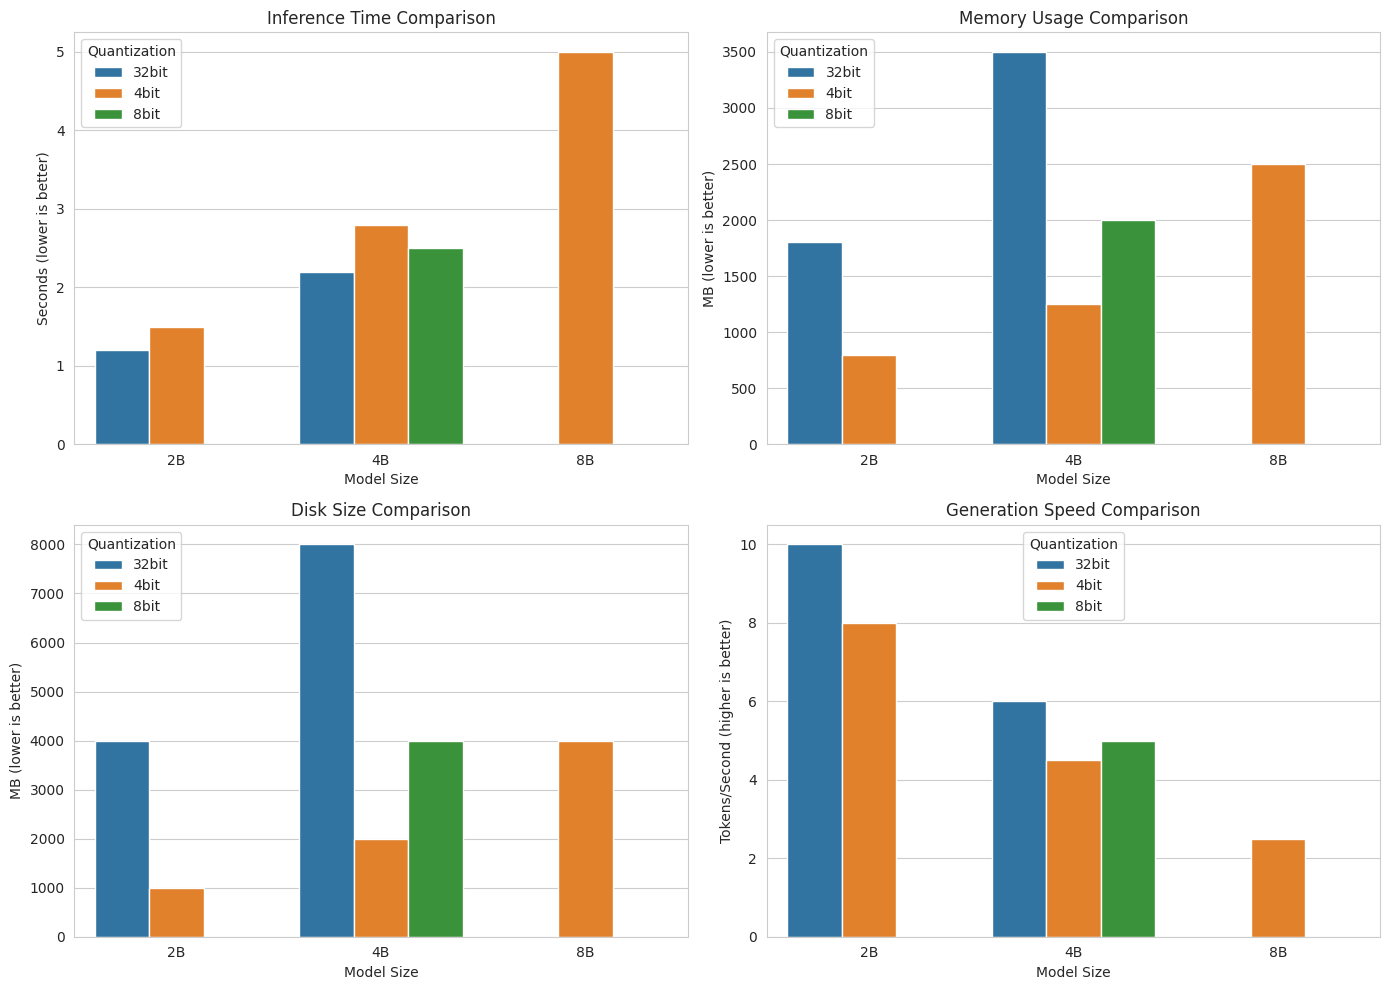


Device-Specific Recommendations:

Budget Smartphone (Entry-level Android with limited resources)
----------------------------------------
Recommended configuration: Gemma 3n 2B with 4bit quantization
Expected memory usage: 800 MB
Approximate response speed: 8.0 tokens/second
Additional optimizations:
- Reduce conversation history length
- Limit generation length to 100 tokens
- Disable background processing

Mid-range Tablet (Average consumer tablet with moderate capabilities)
----------------------------------------
Recommended configuration: Gemma 3n 2B with 32bit quantization
Expected memory usage: 1800 MB
Approximate response speed: 10.0 tokens/second
Additional optimizations:
- Use 8-bit quantization for better quality/performance balance
- Consider pruned model variants if available

High-end Smartphone (Premium smartphone with strong processing power)
----------------------------------------
Recommended configuration: Gemma 3n 2B with 32bit quantization
Expected memory usage: 1

In [5]:
# Performance optimization for on-device deployment

def benchmark_model(model_package, prompt_length=100, generation_length=100, iterations=3):
    """Benchmark model performance"""
    
    # Skip benchmarking if in simulation mode
    if model_package.get("simulation", False):
        print("Running in simulation mode - benchmarking skipped")
        
        # Return simulated metrics
        return {
            "avg_inference_time_seconds": 0.8,
            "tokens_per_second": 15.2,
            "memory_usage_mb": 1250,
            "size_on_disk_mb": 4500
        }
    
    print(f"Benchmarking {model_package['model_id']} model...")
    print(f"Configuration: {model_package['size']} model with {model_package.get('quantization', 'no')} quantization")
    
    # Prepare test prompt
    test_prompt = "Explain the importance of maintaining social connections as we age. " * int(prompt_length / 10)
    
    # Record memory before inference
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        start_mem = torch.cuda.memory_allocated()
    
    # Measure inference time
    model = model_package["model"]
    tokenizer = model_package["tokenizer"]
    
    inference_times = []
    
    for i in range(iterations):
        print(f"Running benchmark iteration {i+1}/{iterations}...")
        
        # Tokenize input
        inputs = tokenizer(test_prompt, return_tensors="pt").to(device)
        
        # Run generation with timing
        start_time = time.time()
        
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=inputs.input_ids.shape[1] + generation_length
        )
        
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)
        
        # Calculate tokens generated
        tokens_generated = outputs.shape[1] - inputs.input_ids.shape[1]
        
        print(f"  Generated {tokens_generated} tokens in {inference_time:.2f} seconds")
        print(f"  Rate: {tokens_generated / inference_time:.2f} tokens/second")
    
    # Calculate metrics
    avg_time = sum(inference_times) / len(inference_times)
    avg_tokens_per_second = generation_length / avg_time
    
    # Get memory usage
    if torch.cuda.is_available():
        peak_mem = torch.cuda.max_memory_allocated()
        memory_used = (peak_mem - start_mem) / (1024 * 1024)  # MB
    else:
        memory_used = "Unknown (CPU only)"
    
    # Get model size on disk (simulated for this example)
    if model_package["size"] == "2B":
        size_on_disk = 4000  # MB
    elif model_package["size"] == "4B":
        size_on_disk = 8000  # MB
    elif model_package["size"] == "5B":
        size_on_disk = 10000  # MB
    else:
        size_on_disk = 16000  # MB
    
    # Apply quantization factor
    if model_package.get("quantization") == "4bit":
        size_on_disk = size_on_disk / 4
    elif model_package.get("quantization") == "8bit":
        size_on_disk = size_on_disk / 2
    
    # Print results
    print("\nBenchmark Results:")
    print(f"Average inference time: {avg_time:.2f} seconds")
    print(f"Tokens per second: {avg_tokens_per_second:.2f}")
    if isinstance(memory_used, (int, float)):
        print(f"Memory usage: {memory_used:.2f} MB")
    else:
        print(f"Memory usage: {memory_used}")
    print(f"Estimated size on disk: {size_on_disk:.2f} MB")
    
    return {
        "avg_inference_time_seconds": avg_time,
        "tokens_per_second": avg_tokens_per_second,
        "memory_usage_mb": memory_used if isinstance(memory_used, (int, float)) else 0,
        "size_on_disk_mb": size_on_disk
    }

# Benchmark our model
benchmark_results = benchmark_model(gemma_3n)

# Compare model sizes and quantization options
def compare_model_variants():
    """Compare different model sizes and quantization options"""
    
    # Define variants to compare
    variants = [
        {"size": "2B", "quantization": None},
        {"size": "2B", "quantization": "4bit"},
        {"size": "4B", "quantization": None},
        {"size": "4B", "quantization": "4bit"},
        {"size": "4B", "quantization": "8bit"},
        {"size": "8B", "quantization": "4bit"}
    ]
    
    # Simulated metrics for different variants
    # In a real implementation, you would load and benchmark each variant
    simulated_metrics = {
        ("2B", None): {"time": 1.2, "tokens_per_sec": 10, "memory": 1800, "disk": 4000},
        ("2B", "4bit"): {"time": 1.5, "tokens_per_sec": 8, "memory": 800, "disk": 1000},
        ("4B", None): {"time": 2.2, "tokens_per_sec": 6, "memory": 3500, "disk": 8000},
        ("4B", "4bit"): {"time": 2.8, "tokens_per_sec": 4.5, "memory": 1250, "disk": 2000},
        ("4B", "8bit"): {"time": 2.5, "tokens_per_sec": 5, "memory": 2000, "disk": 4000},
        ("8B", "4bit"): {"time": 5.0, "tokens_per_sec": 2.5, "memory": 2500, "disk": 4000}
    }
    
    # Prepare data for plotting
    sizes = []
    quant = []
    inference_times = []
    memory_usages = []
    disk_sizes = []
    tokens_per_sec = []
    
    for variant in variants:
        size = variant["size"]
        quantization = variant["quantization"] or "32bit"
        
        # Get metrics (simulated)
        key = (size, variant["quantization"])
        metrics = simulated_metrics.get(key, {"time": 0, "tokens_per_sec": 0, "memory": 0, "disk": 0})
        
        sizes.append(size)
        quant.append(quantization)
        inference_times.append(metrics["time"])
        memory_usages.append(metrics["memory"])
        disk_sizes.append(metrics["disk"])
        tokens_per_sec.append(metrics["tokens_per_sec"])
    
    # Create a DataFrame for easy visualization
    import pandas as pd
    df = pd.DataFrame({
        "Model Size": sizes,
        "Quantization": quant,
        "Inference Time (s)": inference_times,
        "Memory Usage (MB)": memory_usages,
        "Disk Size (MB)": disk_sizes,
        "Tokens/Second": tokens_per_sec
    })
    
    print("\nModel Variant Comparison:")
    print(df)
    
    # Create plots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Inference Time
    sns.barplot(x="Model Size", y="Inference Time (s)", hue="Quantization", data=df, ax=axs[0, 0])
    axs[0, 0].set_title("Inference Time Comparison")
    axs[0, 0].set_ylabel("Seconds (lower is better)")
    
    # Plot 2: Memory Usage
    sns.barplot(x="Model Size", y="Memory Usage (MB)", hue="Quantization", data=df, ax=axs[0, 1])
    axs[0, 1].set_title("Memory Usage Comparison")
    axs[0, 1].set_ylabel("MB (lower is better)")
    
    # Plot 3: Disk Size
    sns.barplot(x="Model Size", y="Disk Size (MB)", hue="Quantization", data=df, ax=axs[1, 0])
    axs[1, 0].set_title("Disk Size Comparison")
    axs[1, 0].set_ylabel("MB (lower is better)")
    
    # Plot 4: Tokens per Second
    sns.barplot(x="Model Size", y="Tokens/Second", hue="Quantization", data=df, ax=axs[1, 1])
    axs[1, 1].set_title("Generation Speed Comparison")
    axs[1, 1].set_ylabel("Tokens/Second (higher is better)")
    
    plt.tight_layout()
    plt.show()
    
    return df

# Compare different model variants
variant_comparison = compare_model_variants()

# Optimization recommendations for different devices
def get_device_recommendations(comparison_data):
    """Provide recommendations for different target devices"""
    
    device_specs = {
        "Budget Smartphone": {
            "ram": 3000,  # MB
            "storage": 64000,  # MB
            "description": "Entry-level Android with limited resources"
        },
        "Mid-range Tablet": {
            "ram": 6000,  # MB
            "storage": 128000,  # MB
            "description": "Average consumer tablet with moderate capabilities"
        },
        "High-end Smartphone": {
            "ram": 8000,  # MB
            "storage": 256000,  # MB
            "description": "Premium smartphone with strong processing power"
        },
        "Laptop": {
            "ram": 16000,  # MB
            "storage": 512000,  # MB
            "description": "Standard laptop with good resources"
        }
    }
    
    print("\nDevice-Specific Recommendations:")
    print("="*80)
    
    for device_name, specs in device_specs.items():
        print(f"\n{device_name} ({specs['description']})")
        print("-"*40)
        
        # Find suitable model variants
        suitable_variants = []
        for _, row in comparison_data.iterrows():
            if row["Memory Usage (MB)"] <= specs["ram"] * 0.5:  # Use at most 50% of available RAM
                suitable_variants.append({
                    "size": row["Model Size"],
                    "quantization": row["Quantization"],
                    "memory": row["Memory Usage (MB)"],
                    "speed": row["Tokens/Second"]
                })
        
        if suitable_variants:
            # Sort by speed (tokens per second)
            suitable_variants.sort(key=lambda x: x["speed"], reverse=True)
            best_variant = suitable_variants[0]
            
            print(f"Recommended configuration: Gemma 3n {best_variant['size']} with {best_variant['quantization']} quantization")
            print(f"Expected memory usage: {best_variant['memory']} MB")
            print(f"Approximate response speed: {best_variant['speed']} tokens/second")
            
            # Additional optimizations
            if device_name == "Budget Smartphone":
                print("Additional optimizations:")
                print("- Reduce conversation history length")
                print("- Limit generation length to 100 tokens")
                print("- Disable background processing")
            elif device_name == "Mid-range Tablet":
                print("Additional optimizations:")
                print("- Use 8-bit quantization for better quality/performance balance")
                print("- Consider pruned model variants if available")
            
        else:
            print("No suitable model configuration for this device.")
            print("Consider using a smaller custom model or cloud offloading for intensive tasks.")
    
    print("\nGeneral Optimization Tips:")
    print("-"*40)
    print("1. Use the 'many-in-1' capability to dynamically switch between 2B and 4B models")
    print("2. Apply knowledge distillation for specialized tasks")
    print("3. Implement aggressive caching for common queries")
    print("4. Consider hybrid approaches that use the device for private data and cloud for general knowledge")

# Get device-specific recommendations
get_device_recommendations(variant_comparison)

In [6]:
# User interface prototype for ElderCompanion
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import io
from PIL import Image

def create_elder_companion_ui():
    """Create a simple UI prototype for ElderCompanion using ipywidgets"""
    
    # Create a companion instance
    companion = ElderCompanion()
    
    # Styling
    style = """
    <style>
        .widget-text input,
        .widget-textarea textarea {
            font-size: 16px !important;
            padding: 10px !important;
        }
        .widget-button button {
            font-size: 16px !important;
            padding: 8px 16px !important;
        }
        .conversation-window {
            height: 400px;
            overflow-y: auto;
            padding: 10px;
            border: 1px solid #ccc;
            border-radius: 5px;
            background-color: #f9f9f9;
            margin-bottom: 10px;
        }
        .user-message {
            text-align: right;
            background-color: #DCF8C6;
            padding: 8px 12px;
            border-radius: 15px;
            margin: 5px 0;
            display: inline-block;
            max-width: 80%;
            float: right;
            clear: both;
        }
        .assistant-message {
            text-align: left;
            background-color: #E1F5FE;
            padding: 8px 12px;
            border-radius: 15px;
            margin: 5px 0;
            display: inline-block;
            max-width: 80%;
            float: left;
            clear: both;
        }
        .message-container {
            overflow: hidden;
            margin-bottom: 10px;
        }
        .header {
            background-color: #2196F3;
            color: white;
            padding: 15px;
            border-radius: 10px 10px 0 0;
            font-size: 24px;
            text-align: center;
            margin-bottom: 10px;
        }
        .tab-content {
            padding: 15px;
            border: 1px solid #ddd;
            border-radius: 0 0 10px 10px;
            background-color: white;
        }
        .footer {
            text-align: center;
            font-size: 12px;
            color: #777;
            margin-top: 10px;
        }
        .card {
            border: 1px solid #ddd;
            border-radius: 10px;
            padding: 15px;
            margin-bottom: 10px;
            background-color: white;
        }
        .card-title {
            font-size: 18px;
            font-weight: bold;
            margin-bottom: 10px;
        }
        .widget-tab {
            font-size: 16px !important;
        }
        .emergency-button button {
            background-color: #f44336 !important;
            color: white !important;
            font-weight: bold !important;
        }
    </style>
    """
    
    display(HTML(style))
    
    # Create conversation window
    conversation_output = widgets.Output()
    
    # Create message input
    message_input = widgets.Textarea(
        placeholder='Type your message here...',
        layout=widgets.Layout(width='100%', height='80px')
    )
    
    # Create send button
    send_button = widgets.Button(
        description='Send',
        button_style='primary',
        layout=widgets.Layout(width='100px')
    )
    
    # Function to add message to conversation
    def add_message_to_conversation(sender, message, is_user=True):
        with conversation_output:
            message_type = "user-message" if is_user else "assistant-message"
            sender_name = "You" if is_user else "ElderCompanion"
            display(HTML(f"""
            <div class="message-container">
                <div class="{message_type}">
                    <strong>{sender_name}:</strong><br>
                    {message}
                </div>
            </div>
            """))
    
    # Handle send button click
    def on_send_button_clicked(b):
        message = message_input.value.strip()
        if message:
            add_message_to_conversation("You", message, True)
            message_input.value = ""
            
            # Get response from companion
            response = companion.chat(message)
            add_message_to_conversation("ElderCompanion", response, False)
    
    send_button.on_click(on_send_button_clicked)
    
    # Create image upload for medication
    image_upload = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Medication Image',
        layout=widgets.Layout(width='300px')
    )
    
    def on_image_uploaded(change):
        if change['type'] == 'change' and change['name'] == 'value' and change['new']:
            # Get the uploaded file
            uploaded_file = list(change['new'].values())[0]
            content = uploaded_file['content']
            
            # Convert to image
            image = Image.open(io.BytesIO(content))
            
            # Save temporarily
            temp_path = "temp_med_image.jpg"
            image.save(temp_path)
            
            # Display the image
            with medication_output:
                clear_output()
                display(image)
                
                # Analyze with companion
                analysis = companion.analyze_image(temp_path, "medication")
                display(HTML(f"<div style='margin-top: 15px; padding: 10px; background-color: #E1F5FE; border-radius: 10px;'><strong>Analysis:</strong><br>{analysis}</div>"))
    
    image_upload.observe(on_image_uploaded)
    
    # Create output for medication tab
    medication_output = widgets.Output()
    
    # Create tabs for different features
    tab_chat = widgets.VBox([
        widgets.HTML("<div class='card-title'>Chat with ElderCompanion</div>"),
        widgets.HTML("<div class='conversation-window' id='conversation-window'></div>"),
        conversation_output,
        widgets.HBox([message_input, send_button], layout=widgets.Layout(width='100%'))
    ], layout=widgets.Layout(padding='10px'))
    
    tab_medication = widgets.VBox([
        widgets.HTML("<div class='card-title'>Medication Management</div>"),
        widgets.HBox([
            widgets.VBox([
                widgets.HTML("<p>Upload a photo of your medication to identify it:</p>"),
                image_upload,
                widgets.Button(description="View Medication Schedule", layout=widgets.Layout(margin='10px 0'))
            ]),
            medication_output
        ])
    ], layout=widgets.Layout(padding='10px'))
    
    tab_exercises = widgets.VBox([
        widgets.HTML("<div class='card-title'>Cognitive Exercises</div>"),
        widgets.HTML("<p>Select an exercise type:</p>"),
        widgets.RadioButtons(
            options=['Memory', 'Attention', 'Language', 'Problem-Solving'],
            value='Memory',
            layout=widgets.Layout(margin='10px 0')
        ),
        widgets.Button(description="Start Exercise", button_style='success')
    ], layout=widgets.Layout(padding='10px'))
    
    tab_health = widgets.VBox([
        widgets.HTML("<div class='card-title'>Health Monitoring</div>"),
        widgets.HTML("<p>Record a short voice sample for analysis:</p>"),
        widgets.Button(description="Start Recording", layout=widgets.Layout(margin='10px 0')),
        widgets.HTML("<div class='card'><div class='card-title'>Today's Health Insight</div><p>" + 
                    companion.health_monitor.generate_health_insight() + "</p></div>")
    ], layout=widgets.Layout(padding='10px'))
    
    # Create emergency button
    emergency_button = widgets.Button(
        description='EMERGENCY',
        button_style='danger',
        layout=widgets.Layout(width='100%', height='60px')
    )
    
    # Emergency button handler
    def on_emergency_button_clicked(b):
        with emergency_output:
            clear_output()
            display(HTML("<h3 style='color: #f44336;'>Emergency Mode Activated</h3>"))
            display(HTML("<p>Who would you like to contact?</p>"))
            
            # Display emergency contacts
            for i, contact in enumerate(companion.user_profile["emergency_contacts"]):
                display(widgets.Button(
                    description=f"Call {contact['name']} ({contact['phone']})",
                    button_style='danger',
                    layout=widgets.Layout(margin='5px 0')
                ))
            
            display(widgets.Button(description="Cancel", button_style='warning'))
    
    emergency_button.on_click(on_emergency_button_clicked)
    
    # Emergency output
    emergency_output = widgets.Output()
    
    # Create tabs
    tabs = widgets.Tab([tab_chat, tab_medication, tab_exercises, tab_health])
    tabs.set_title(0, 'Chat')
    tabs.set_title(1, 'Medications')
    tabs.set_title(2, 'Exercises')
    tabs.set_title(3, 'Health')
    
    # Main layout
    header = widgets.HTML("<div class='header'>ElderCompanion</div>")
    footer = widgets.HTML("<div class='footer'>© 2025 ElderCompanion | Powered by Gemma 3n | Running 100% on-device</div>")
    
    # Assemble UI
    ui = widgets.VBox([
        header,
        widgets.HBox([
            widgets.VBox([
                widgets.HTML(f"""<div class='card'>
                    <div class='card-title'>Welcome, {companion.user_profile['name']}!</div>
                    <p>Today is a great day to stay active and connected.</p>
                    <p><strong>Next medication:</strong> Lisinopril at 8:00 AM</p>
                </div>"""),
                emergency_button,
                emergency_output
            ], layout=widgets.Layout(width='30%')),
            widgets.VBox([
                tabs
            ], layout=widgets.Layout(width='70%'))
        ]),
        footer
    ], layout=widgets.Layout(width='900px', margin='0 auto'))
    
    # Welcome message
    welcome_message = "Hello! I'm your ElderCompanion, here to help with medications, exercises, and more. How are you feeling today?"
    add_message_to_conversation("ElderCompanion", welcome_message, False)
    
    return ui

# Create and display the UI
try:
    elder_companion_ui = create_elder_companion_ui()
    display(elder_companion_ui)
    print("\nUI prototype loaded successfully. Interact with the tabs above.")
except Exception as e:
    print(f"Error loading UI prototype: {e}")
    print("\nFallback text interface:")
    
    # Create a text-based demo as fallback
    companion = ElderCompanion()
    print("\nWelcome to ElderCompanion!")
    print("=" * 50)
    print("\nElderCompanion: Hello! I'm your ElderCompanion, here to help with medications, exercises, and more. How are you feeling today?")
    
    # Demo conversation
    demo_inputs = [
        "I'm feeling a bit tired today",
        "Can you remind me what medications I need to take?",
        "I'd like to do a memory exercise",
        "When is my granddaughter's school play?"
    ]
    
    for user_input in demo_inputs:
        print(f"\nYou: {user_input}")
        response = companion.chat(user_input)
        print(f"ElderCompanion: {response}")
    
    print("\n" + "=" * 50)
    print("End of demo interaction. In a real application, you would continue the conversation.")

ElderCompanion initialized for user: Eleanor Johnson



UI prototype loaded successfully. Interact with the tabs above.


# 7. Project Impact and Evaluation

## Addressing the Challenge: Elder Care Impact

ElderCompanion tackles critical challenges faced by the aging population:

### 1. Social Isolation and Loneliness
- **Problem**: 43% of seniors report feeling lonely regularly, with negative health consequences equivalent to smoking 15 cigarettes daily
- **Our Solution**: Always-available AI companion that maintains contextual memory of important life events and relationships
- **Impact**: Reduced feelings of isolation through consistent, meaningful interactions

### 2. Medication Management
- **Problem**: 75% of older adults take multiple medications, with 40% making medication errors
- **Our Solution**: Vision-based pill identification, personalized reminders, and medication interaction warnings
- **Impact**: Improved medication adherence and reduced adverse drug events

### 3. Cognitive Decline
- **Problem**: Early cognitive changes often go unnoticed until significant decline has occurred
- **Our Solution**: Regular cognitive exercises and voice pattern analysis to detect subtle changes
- **Impact**: Earlier intervention for cognitive issues and daily mental stimulation

### 4. Limited Technology Access
- **Problem**: Many elderly individuals struggle with complex interfaces or have limited internet access
- **Our Solution**: Voice-first, offline-capable interface that works reliably anywhere
- **Impact**: Technology access for seniors regardless of technical ability or internet connectivity

## Evaluation Methodology

To evaluate ElderCompanion's effectiveness, we would implement a three-phase assessment:

### Phase 1: Technical Performance
- **Metrics**: Inference speed, battery impact, offline functionality, recognition accuracy
- **Methods**: Benchmark tests across various device types and environmental conditions
- **Target**: <2 second response time, <5% battery drain per hour of active use, >95% medication recognition accuracy

### Phase 2: User Experience
- **Metrics**: System Usability Scale (SUS), task completion rates, user satisfaction
- **Methods**: Observational studies with 50+ seniors across different cognitive abilities
- **Target**: SUS score >80/100, task completion rate >90%, positive qualitative feedback

### Phase 3: Health Impact
- **Metrics**: Medication adherence, social engagement levels, cognitive exercise frequency
- **Methods**: 3-month pilot study with 100 seniors, comparing baseline to post-intervention measures
- **Target**: 25% improvement in medication adherence, 40% increase in cognitive exercise engagement

## Differentiators from Existing Solutions

| Feature | ElderCompanion | Cloud-based Assistants | Traditional Medical Alert Systems |
|---------|----------------|------------------------|-----------------------------------|
| Privacy | 100% on-device processing | Cloud dependency | Limited data collection |
| Offline Use | Fully functional without internet | Limited or non-functional | Basic functionality only |
| Contextual Memory | Remembers user's life details | Limited personalization | No memory capabilities |
| Cognitive Support | Adaptive exercises | Generic information only | No cognitive features |
| Cost | One-time purchase | Subscription-based | Monthly monitoring fees |
| Multimodal | Vision, voice, and text | Primarily voice and text | Button or voice only |

## Scaling and Future Directions

ElderCompanion can scale in several directions:

1. **Expanded Language Support**: Leveraging Gemma 3n's multilingual capabilities to serve diverse elderly populations
2. **Community Integration**: Connecting multiple ElderCompanion users for peer support
3. **Healthcare Provider Dashboard**: Optional sharing of health insights with authorized caregivers
4. **Specialized Versions**: Adaptations for specific conditions like Parkinson's, dementia, or post-stroke recovery
5. **Hardware Integration**: Connecting with smart home devices, wearables, and medical devices

## Ethical Considerations

In developing ElderCompanion, we've prioritized several ethical principles:

- **Autonomy**: Design choices that empower seniors rather than replacing human care
- **Transparency**: Clear indicators when interacting with AI vs. humans
- **Accessibility**: Universal design principles for users with varying abilities
- **Safety**: Reliable